In [ ]:
%pip install numpy
%pip install --upgrade --force-reinstall scipy
%pip install matplotlib

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [23]:
# Set a random seed for reproducibility
np.random.seed(42)

In [24]:
# Parameters
# Parameters
T = 1000  # Time-series length
n_x = 1  # Number of hidden states
n_w = n_x  # Number of process error terms

n_w2hat = n_x * (n_x + 1) / 2  # Total number of variance and covariance terms
y = np.zeros(T)  # Initialization of the vector of observations

# Q matrix
sW = np.sqrt(1.35)  # 0.42, 1.35, 18.75 - Possible values for the true error variances
Q = sW ** 2

# R matrix
QR_ratio = 10  # Q/R = (sigma_W)^2 / (sigma_V)^2
R = Q / QR_ratio
sV = np.sqrt(R)


In [25]:
# Data
YT = np.zeros((n_x, T))
x_true = np.zeros((n_x, T))
x_true[:, 0] = 0
w = np.dot(sW, np.random.randn(n_x, T))
v = np.dot(sV, np.random.randn(n_x, T))

for t in range(1, T):
    A_t = 0.8 - 0.1 * np.sin(7 * np.pi * t / T)  # Transition equation
    C_t = 1 - 0.99 * np.sin(100 * np.pi * t / T)  # Observation equation
    x_true[:, t] = A_t * x_true[:, t - 1] + w[:, t]
    YT[:, t] = C_t * x_true[:, t] + v[:, t]

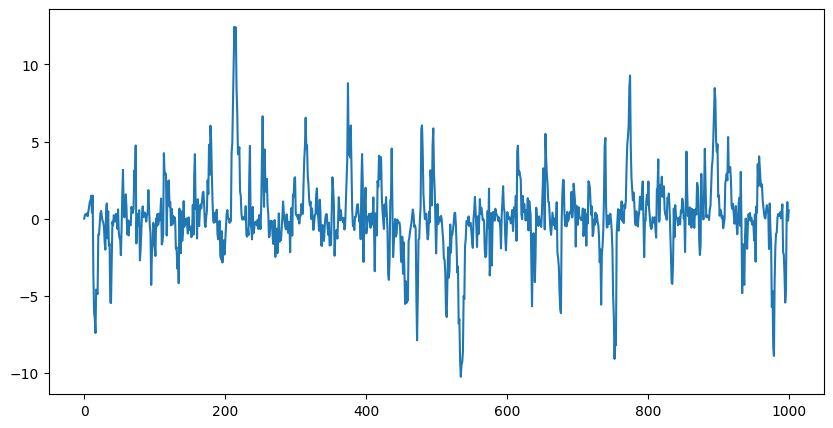

In [26]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(YT[0, :], label='Observations')
plt.show()

In [27]:
# Initialization

mw2 = 2  # Initial mean for \overline{W^2}
sw2 = 1  # Initial variance for \overline{W^2}

EX = np.zeros((3, T))  # X = [X  W  \overline{W^2}]
EX[:, 0] = np.transpose([0, np.nan, mw2]) # Initial mean is zero
print(EX.shape)
PX = np.zeros((3, 3, T))
PX[:, :, 0] = np.diag([100, np.nan, sw2 ** 2])  # Initial variance is 100
print(PX[:, :, 0])

(3, 1000)
[[100.   0.   0.]
 [  0.  nan   0.]
 [  0.   0.   1.]]


In [28]:
for t in range(1, T):
    A = 0.8 - 0.1 * np.sin(7 * np.pi * t / T)  # Transition equation
    Ep = np.transpose([A * EX[0, t - 1], 0])  # Mean of W is zero
    Ep = Ep.reshape(Ep.shape[0], 1)
    m_w2hat = EX[2, t - 1]
    s_w_sq = m_w2hat

    Sp = np.array([[A ** 2 * PX[0, 0, t - 1] + s_w_sq, s_w_sq],
                   [s_w_sq, s_w_sq]])

    C = np.array([1 - 0.99 * np.sin(100 * np.pi * t / T), 0])  # Observation equation
    
    SY = C @ Sp @ C.T + R
    SYX = Sp @ C.T
    my = C @ Ep
    K = SYX / SY
    K = K.reshape(K.shape[0], 1)
    
    e = YT[:, t] - my
    e = e.reshape(e.shape[0], 1)
    SYX = SYX.reshape(SYX.shape[0], 1)
    
    EX1 = Ep + K @ e
    # print(EX1)
    PX1 = Sp - K @ SYX.T
    # print(PX1)
    
    EX1 = np.reshape(EX1, (EX1.shape[0],))
    EX[0:2, t] = EX1
    PX[0:2, 0:2, t] = PX1
    v = YT[:, t] - my
    # 2nd Update step
    s_w2_sq = 2 * EX[2, t - 1] ** 2
    m_w2 = EX[1, t] ** 2 + PX[1, 1, t]
    s_w2 = 2 * PX[1, 1, t] ** 2 + 4 * PX[1, 1, t] * EX[1, t] ** 2
    my1 = EX[2, t - 1]
    SYX1 = PX[2, 2, t - 1]

    # Smoother Equations
    E_W2_pos = m_w2
    E_W2_prior = my1
    C_W2_W2hat = SYX1
    P_W2_prior = 3 * PX[2, 2, t - 1] + s_w2_sq
    P_W2_pos = s_w2
    J = C_W2_W2hat / P_W2_prior
    EX[2, t] = EX[2, t - 1] + J * (E_W2_pos - E_W2_prior)
    PX[2, 2, t] = PX[2, 2, t - 1] + J ** 2 * P_W2_pos - C_W2_W2hat ** 2 / P_W2_prior

    


In [29]:
estim_sigma_w = EX[2, -1]
estim_sigma_w_P = PX[2, 2, -1]

print('Estimated variance: ', estim_sigma_w)
print('Estimated variance of variance: ', estim_sigma_w_P)



Estimated variance:  1.2886003801984707
Estimated variance of variance:  0.006255660179747821


In [30]:
## Hypothesis Testing
alpha = 0.05  # Significance level
df = T - 1  # Degrees of freedom
t_critical = stats.t.ppf(1 - alpha / 2, df)  # t-critical value for a two-tailed test

# Calculating the test statistic
x_bar = estim_sigma_w
mu = sW ** 2
s = np.sqrt(estim_sigma_w_P)
t_statistic = (x_bar - mu) / (s / np.sqrt(1))

# Testing the null hypothesis
if abs(t_statistic) > t_critical:
    print(f"Reject the null hypothesis at the {100 * (1 - alpha):.2f}% significance level.")
else:
    print(f"Fail to reject the null hypothesis at the {100 * (1 - alpha):.2f}% significance level.")


Fail to reject the null hypothesis at the 95.00% significance level.


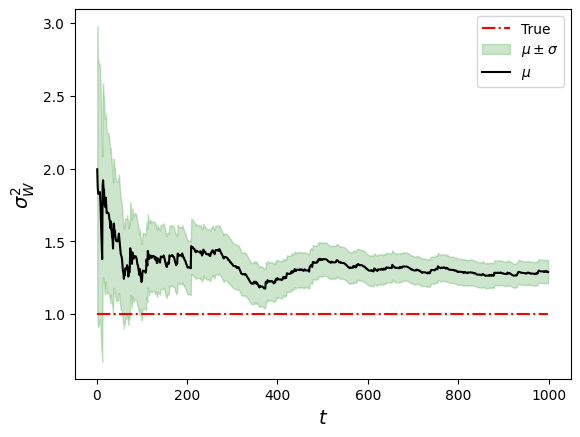

In [31]:
## Plotting Sigma_W
t = np.arange(1, len(EX[2]))
xw = EX[2, t]
sX = np.sqrt(PX[2, 2, t])
plt.figure()
plt.plot(t, np.full_like(t, sW ** 2), '-.r', linewidth=1.5)
plt.fill_between(t, xw + sX, xw - sX, color='g', alpha=0.2)
plt.plot(t, xw, 'k')
plt.legend(['True', '$\mu \pm \sigma$', '$\mu$'], loc='best')
plt.xlabel('$t$', fontsize=14)
plt.ylabel('$\sigma^2_W$', fontsize=14)
plt.show()